In [3]:
import os
import shutil
import xml.etree.ElementTree as ET

# Directorios de entrada y salida
imagenes_dir = "split_2"
anotaciones_dir = "split2_saved"
dataset_dir = "dataset"

# Crear la carpeta de salida si no existe
os.makedirs(dataset_dir, exist_ok=True)

# Obtener lista de archivos de anotaciones
for xml_file in os.listdir(anotaciones_dir):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(anotaciones_dir, xml_file)
        
        # Parsear el archivo XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Obtener el nombre del archivo de imagen
        image_filename = root.find("filename").text
        image_path = os.path.join(imagenes_dir, image_filename)
        
        # Iterar sobre los objetos anotados
        for obj in root.findall("object"):
            character = obj.find("name").text  # Obtener el carácter anotado
            
            # Crear carpeta para el carácter si no existe
            char_dir = os.path.join(dataset_dir, character)
            images_dir = os.path.join(char_dir, "images")
            annotations_dir = os.path.join(char_dir, "annotations")
            os.makedirs(images_dir, exist_ok=True)
            os.makedirs(annotations_dir, exist_ok=True)
            
            # Copiar la imagen a la carpeta correspondiente
            target_image_path = os.path.join(images_dir, image_filename)
            shutil.copy(image_path, target_image_path)
            
            # Copiar la anotación a la carpeta correspondiente
            target_annotation_path = os.path.join(annotations_dir, xml_file)
            shutil.copy(xml_path, target_annotation_path)

print("Organización completada. Las imágenes y anotaciones se han distribuido en la carpeta 'dataset' por carácter.")


Organización completada. Las imágenes y anotaciones se han distribuido en la carpeta 'dataset' por carácter.


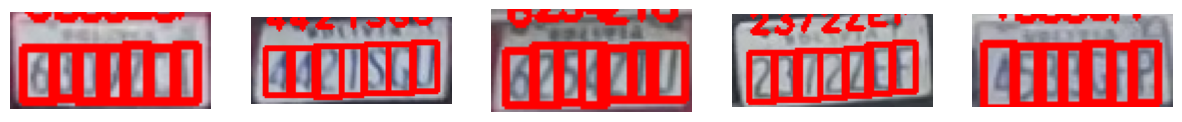

In [4]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import random

# Directorio del dataset organizado
dataset_dir = "dataset"

def draw_annotations(image_path, annotation_path):
    """Dibuja las anotaciones en la imagen."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    for obj in root.findall("object"):
        character = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = [int(bbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]
        
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, character, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    return image

def show_sample_images(num_samples=5):
    """Muestra un lote de imágenes con sus anotaciones."""
    char_dirs = [os.path.join(dataset_dir, d) for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    sample_images = []
    
    for char_dir in char_dirs:
        images_dir = os.path.join(char_dir, "images")
        annotations_dir = os.path.join(char_dir, "annotations")
        
        images = os.listdir(images_dir)
        if images:
            random_image = random.choice(images)
            image_path = os.path.join(images_dir, random_image)
            annotation_path = os.path.join(annotations_dir, random_image.replace(".jpg", ".xml"))
            
            if os.path.exists(annotation_path):
                sample_images.append((image_path, annotation_path))
                if len(sample_images) >= num_samples:
                    break
    
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    if len(sample_images) == 1:
        axes = [axes]
    
    for ax, (img_path, ann_path) in zip(axes, sample_images):
        annotated_image = draw_annotations(img_path, ann_path)
        ax.imshow(annotated_image)
        ax.axis("off")
    
    plt.show()

# Mostrar imágenes de ejemplo
show_sample_images()

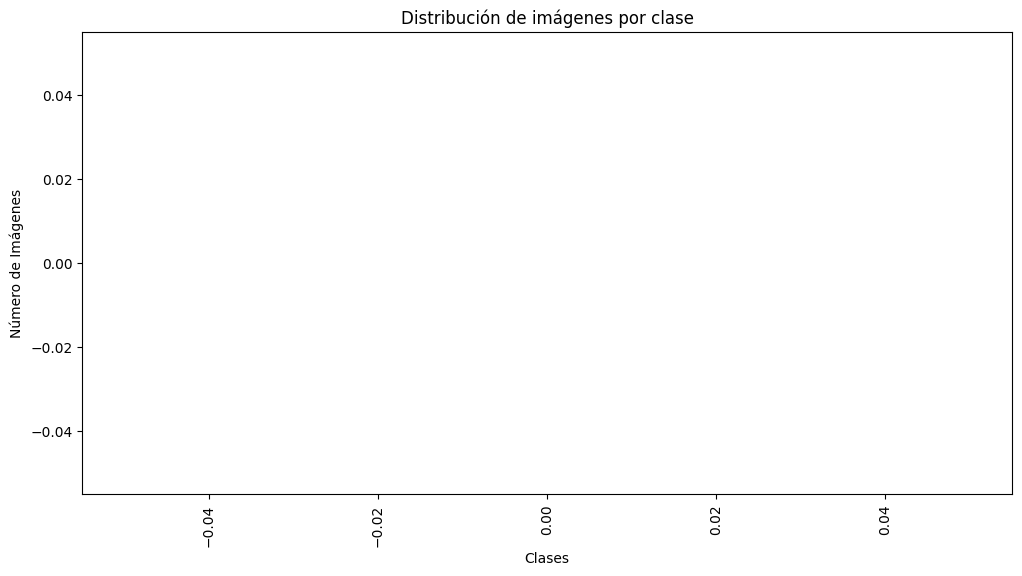

In [8]:
import os
import matplotlib.pyplot as plt

# Directorio del dataset organizado
dataset_dir = "dataset_yolo"

def count_images_per_class():
    """Cuenta la cantidad de imágenes en cada clase."""
    class_counts = {}
    
    for char_dir in os.listdir(dataset_dir):
        char_path = os.path.join(dataset_dir, char_dir, "images")
        if os.path.isdir(char_path):
            class_counts[char_dir] = len(os.listdir(char_path))
    
    return class_counts

def plot_class_distribution():
    """Grafica el desbalance de clases."""
    class_counts = count_images_per_class()
    
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts)
    plt.xlabel("Clases")
    plt.ylabel("Número de Imágenes")
    plt.title("Distribución de imágenes por clase")
    plt.xticks(rotation=90)
    plt.show()

# Mostrar el gráfico del desbalance de clases
plot_class_distribution()


In [6]:
import os
import xml.etree.ElementTree as ET

# Directorios de entrada y salida
dataset_dir = "dataset"
yolo_dataset_dir = "dataset_yolo"
os.makedirs(yolo_dataset_dir, exist_ok=True)

# Crear diccionario de clases
class_dict = {}
class_index = 0

def convert_to_yolo_format(xml_path, image_width, image_height):
    """Convierte las anotaciones XML a formato YOLO."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_annotations = []
    
    for obj in root.findall("object"):
        character = obj.find("name").text
        if character not in class_dict:
            global class_index
            class_dict[character] = class_index
            class_index += 1
        class_id = class_dict[character]
        
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = [int(bbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]
        
        # Convertir a formato YOLO (x_center, y_center, width, height) en valores normalizados
        x_center = ((xmin + xmax) / 2) / image_width
        y_center = ((ymin + ymax) / 2) / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    return yolo_annotations

for char_dir in os.listdir(dataset_dir):
    images_dir = os.path.join(dataset_dir, char_dir, "images")
    annotations_dir = os.path.join(dataset_dir, char_dir, "annotations")
    yolo_char_dir = os.path.join(yolo_dataset_dir, char_dir)
    os.makedirs(yolo_char_dir, exist_ok=True)
    
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            annotation_path = os.path.join(annotations_dir, image_file.replace(".jpg", ".xml"))
            
            if os.path.exists(annotation_path):
                # Obtener tamaño de imagen
                image = cv2.imread(image_path)
                h, w, _ = image.shape
                
                yolo_annotations = convert_to_yolo_format(annotation_path, w, h)
                
                # Guardar anotaciones en formato YOLO
                yolo_annotation_path = os.path.join(yolo_char_dir, image_file.replace(".jpg", ".txt"))
                with open(yolo_annotation_path, "w") as f:
                    f.write("\n".join(yolo_annotations))
                
                # Copiar imagen al nuevo dataset
                shutil.copy(image_path, os.path.join(yolo_char_dir, image_file))

# Guardar el diccionario de clases
class_dict_path = os.path.join(yolo_dataset_dir, "classes.txt")
with open(class_dict_path, "w") as f:
    for char, index in class_dict.items():
        f.write(f"{index} {char}\n")

print("Conversión a formato YOLO completada. Dataset guardado en 'dataset_yolo'.")


Conversión a formato YOLO completada. Dataset guardado en 'dataset_yolo'.


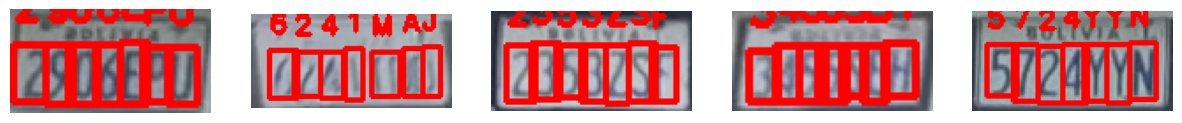

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Directorio del dataset en formato YOLO
yolo_dataset_dir = "dataset_yolo"

# Cargar clases
class_dict_path = os.path.join(yolo_dataset_dir, "classes.txt")
class_dict = {}
if os.path.exists(class_dict_path):
    with open(class_dict_path, "r") as f:
        for line in f:
            index, char = line.strip().split(" ")
            class_dict[int(index)] = char

def draw_yolo_annotations(image_path, annotation_path):
    """Dibuja las anotaciones en la imagen desde el formato YOLO."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    with open(annotation_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            xmin = int((x_center - width / 2) * w)
            ymin = int((y_center - height / 2) * h)
            xmax = int((x_center + width / 2) * w)
            ymax = int((y_center + height / 2) * h)
            
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image, class_dict[class_id], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    return image

def show_sample_yolo_images(num_samples=5):
    """Muestra un lote de imágenes con sus anotaciones en formato YOLO."""
    char_dirs = [os.path.join(yolo_dataset_dir, d) for d in os.listdir(yolo_dataset_dir) if os.path.isdir(os.path.join(yolo_dataset_dir, d))]
    sample_images = []
    
    for char_dir in char_dirs:
        images = [f for f in os.listdir(char_dir) if f.endswith(".jpg")]
        if images:
            random_image = random.choice(images)
            image_path = os.path.join(char_dir, random_image)
            annotation_path = os.path.join(char_dir, random_image.replace(".jpg", ".txt"))
            
            if os.path.exists(annotation_path):
                sample_images.append((image_path, annotation_path))
                if len(sample_images) >= num_samples:
                    break
    
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    if len(sample_images) == 1:
        axes = [axes]
    
    for ax, (img_path, ann_path) in zip(axes, sample_images):
        annotated_image = draw_yolo_annotations(img_path, ann_path)
        ax.imshow(annotated_image)
        ax.axis("off")
    
    plt.show()

# Mostrar imágenes de ejemplo en formato YOLO
show_sample_yolo_images()